In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Need to get our fact table from BigQuery

In [4]:
%%bigquery results --project dt-grad-emea3-cap-dev
SELECT * FROM `dt-grad-emea3-cap-dev.dataform.fct_vehicle_listings`

Query is running:   0%|          |

Downloading:   0%|          |

# Loading in potentially informative columns
I am not going to investigate columns like url, VIN, any price-derived columns, avg lat/long, posting date etc that clearly aren't helpful for price prediction

In [5]:
#Only retrieving columns that might be informative for the ML model.
df = results[['price', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'lat', 'long', 'cylinder_count', 'car_year', 'car_region', 'car_condition', 'state']]
df

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
0,4995,bmw,3 series,gas,164171.0,clean,automatic,39.937155,-75.088194,6,2007,south jersey,good,nj
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,31.453312,-100.464064,8,2015,odessa / midland,good,tx
2,16995,mitsubishi,mirage,gas,5773.0,clean,automatic,29.148519,-98.875934,3,2020,laredo,good,tx
3,17000,lincoln,mkc,gas,90457.0,clean,automatic,43.204762,-75.440834,4,2015,watertown,excellent,ny
4,32995,ford,f-150,gas,106000.0,clean,automatic,47.714927,-116.790784,8,2014,spokane,excellent,id
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117197,7650,nissan,pathfinder s,gas,134242.0,clean,automatic,38.583871,-90.244449,6,2008,"st louis, MO",excellent,il
117198,9485,toyota,rav4,gas,141569.0,clean,automatic,39.124201,-90.960960,4,2011,"st louis, MO",excellent,il
117199,20864,chrysler,300,gas,61103.0,clean,None,38.802269,-90.673649,6,2018,"st louis, MO",excellent,il
117200,26900,ford,e-450 cutaway e-450 sd drw,gas,81136.0,clean,automatic,NaN,NaN,8,2016,"st louis, MO",excellent,il


First of all I want to do a quick check of our target column 'price'

In [6]:
# Are there any negative prices? Shouldn't be...
df[df['price'] < 0]

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state


In [7]:
# How do we want to get rid of price outliers?

price_lower_bound = 1000 # Many listings are $0
price_upper_bound = df['price'].quantile(0.999) # Get rid of the crazily priced cars. >$X00,000
print(f"Only including cars between ${price_lower_bound} and ${price_upper_bound}")

bounded_price_df = df[(df['price'] >= price_lower_bound) & (df['price'] <= price_upper_bound)]
bounded_price_df

Only including cars between $1000 and $111417.01700000522


,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
0,4995,bmw,3 series,gas,164171.0,clean,automatic,39.937155,-75.088194,6,2007,south jersey,good,nj
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,31.453312,-100.464064,8,2015,odessa / midland,good,tx
2,16995,mitsubishi,mirage,gas,5773.0,clean,automatic,29.148519,-98.875934,3,2020,laredo,good,tx
3,17000,lincoln,mkc,gas,90457.0,clean,automatic,43.204762,-75.440834,4,2015,watertown,excellent,ny
4,32995,ford,f-150,gas,106000.0,clean,automatic,47.714927,-116.790784,8,2014,spokane,excellent,id
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117197,7650,nissan,pathfinder s,gas,134242.0,clean,automatic,38.583871,-90.244449,6,2008,"st louis, MO",excellent,il
117198,9485,toyota,rav4,gas,141569.0,clean,automatic,39.124201,-90.960960,4,2011,"st louis, MO",excellent,il
117199,20864,chrysler,300,gas,61103.0,clean,None,38.802269,-90.673649,6,2018,"st louis, MO",excellent,il
117200,26900,ford,e-450 cutaway e-450 sd drw,gas,81136.0,clean,automatic,NaN,NaN,8,2016,"st louis, MO",excellent,il


# Investigating columns

## Manufacturer/Model
While there are thousands of models, only a few dozen are likely to have enough data (a few hundred entries) for accurate price predictions. By filtering for models with sufficient data, we reduce the dataset size but improve its quality for prediction. This approach limits accurate price predictions to the included models, but since these are popular cars, they are likely the ones CarsClassified will prioritize for price estimation.

In [8]:
bounded_price_df['model'].nunique()

15220

Here we can see a list of the models that have above a certain threshold of data

In [9]:
bounded_price_df.groupby(['manufacturer', 'model']).size().loc[lambda x: x > 500].sort_values(ascending=False)

,,0
manufacturer,model,
ford,f-150,2268
chevrolet,silverado 1500,1351
ram,1500,1123
ford,escape,912
toyota,camry,873
jeep,grand cherokee,764
nissan,altima,744
honda,civic,734
ford,explorer,713


We will filter the data to only include the car models that have enough data. Below is a plot to show how each model of these models compare price-wise





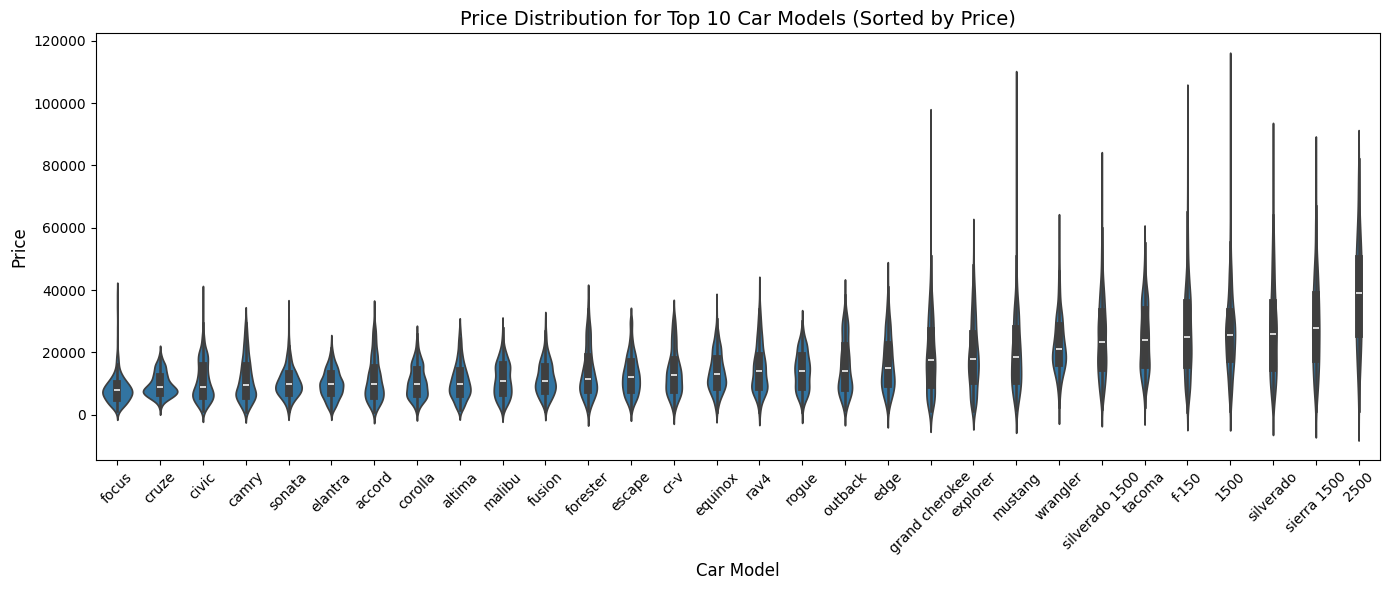

In [10]:
top_models = bounded_price_df['model'].value_counts().nlargest(30).index # Set to TOP 30 models atm
top_models_df = bounded_price_df[bounded_price_df['model'].isin(top_models)]
sorted_models = top_models_df.groupby('model')['price'].median().sort_values(ascending=True).index

# Create the violin plot
plt.figure(figsize=(14, 6))  # Adjust the figure size for better visibility
sns.violinplot(x='model', y='price', data=top_models_df, order=sorted_models)
plt.xticks(rotation=45)
plt.title('Price Distribution for Top 10 Car Models (Sorted by Price)', fontsize=14)
plt.xlabel('Car Model', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.show()

Below is a table to give more context to the violin plots above. The table shows the maximum and minimum price of each of the models.

Also you might think the violin plots above shows prices below zero, but I think that's just how violin plots work, something to do with kernal density?

In [11]:
top_models_df.groupby('model')['price'].agg(['min', 'max', 'median']).sort_values(by='median', ascending=True)

,min,max,median
model,,,
focus,1299,39499,7823.0
cruze,2200,19998,8900.0
civic,1100,37995,8999.0
camry,1000,31048,9700.0
sonata,1200,33988,9850.0
elantra,1000,22988,9950.0
accord,1000,32988,9950.0
corolla,1000,25784,9978.0
altima,1450,27988,9989.0


In [12]:
top_models_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,31.453312,-100.464064,8,2015,odessa / midland,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,47.714927,-116.790784,8,2014,spokane,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,36.644835,-93.218011,6,2008,joplin,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,29.148519,-98.875934,6,2019,laredo,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,29.148519,-98.875934,4,2015,san antonio,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117179,9995,ford,fusion,gas,117138.0,clean,automatic,40.859538,-73.075599,4,2016,long island,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,44.971567,-93.488809,6,2010,minneapolis / st paul,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,45.197295,-93.901667,6,2018,minneapolis / st paul,good,mn
117195,4250,hyundai,elantra,gas,187570.0,clean,manual,38.479493,-90.741664,4,2010,"st louis, MO",good,il


## Odometer


I want to show how many cars have very low mileage and high milage

In [13]:
# Showing cars with low mileage
top_models_df[top_models_df['odometer']< 1000]

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
242,3800,chevrolet,equinox,gas,1.0,clean,automatic,41.622595,-87.633814,4,2011,milwaukee,good,wi
960,29998,gmc,sierra 1500,gas,100.0,clean,automatic,36.129540,-79.957520,8,2014,greensboro,good,nc
1342,19900,nissan,rogue,gas,397.0,clean,automatic,27.481331,-82.571899,4,2020,sarasota-bradenton,excellent,fl
2275,1900,hyundai,elantra,gas,1.0,clean,automatic,41.622595,-87.633814,<NA>,2009,milwaukee,good,wi
2276,3100,nissan,altima,gas,1.0,clean,None,41.622595,-87.633814,4,2011,milwaukee,good,wi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115225,3100,ford,f-150,gas,1.0,clean,automatic,41.622595,-87.633814,8,2006,milwaukee,good,wi
115623,45991,toyota,tacoma,gas,208.0,clean,automatic,45.381450,-122.606475,6,2021,portland,good,or
116063,27950,chevrolet,silverado 1500,gas,888.0,salvage,automatic,25.827103,-80.241520,6,2021,austin,good,tx
116736,11900,chevrolet,cruze,gas,808.0,salvage,automatic,41.580397,-93.557596,4,2018,des moines,good,ia


In [14]:
# Showing cars with very high mileage
top_models_df[top_models_df['odometer'] > 500000]

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
21729,6900,ford,escape,gas,525820.0,clean,automatic,29.68652,-82.321830,6,2011,gainesville,excellent,fl
28339,4500,ford,mustang,gas,888888.0,clean,manual,34.52422,-84.916984,8,1986,northwest GA,good,ga
103362,16672,ford,edge,gas,756110.0,clean,automatic,30.08502,-97.819430,4,2015,austin,excellent,tx


I will filter out rows that have very low or high mileage.

Also, maybe we should get rid of odometer values that have all the same number like 9999999 or 8888888 or are like 123456 as well, becuase they are likely fake.

In [15]:
odo_lower_bound = 1000
odo_upper_bound = 500000
print(f"Only including cars that claim between {odo_lower_bound} and {odo_upper_bound} miles on the odo")

bounded_odometer_df = top_models_df[(top_models_df['odometer'] >= odo_lower_bound) & (top_models_df['odometer'] <= odo_upper_bound)]

Only including cars that claim between 1000 and 500000 miles on the odo


Below is a plot to show how the price varies depending on odometer readings for each car model in our dataframe

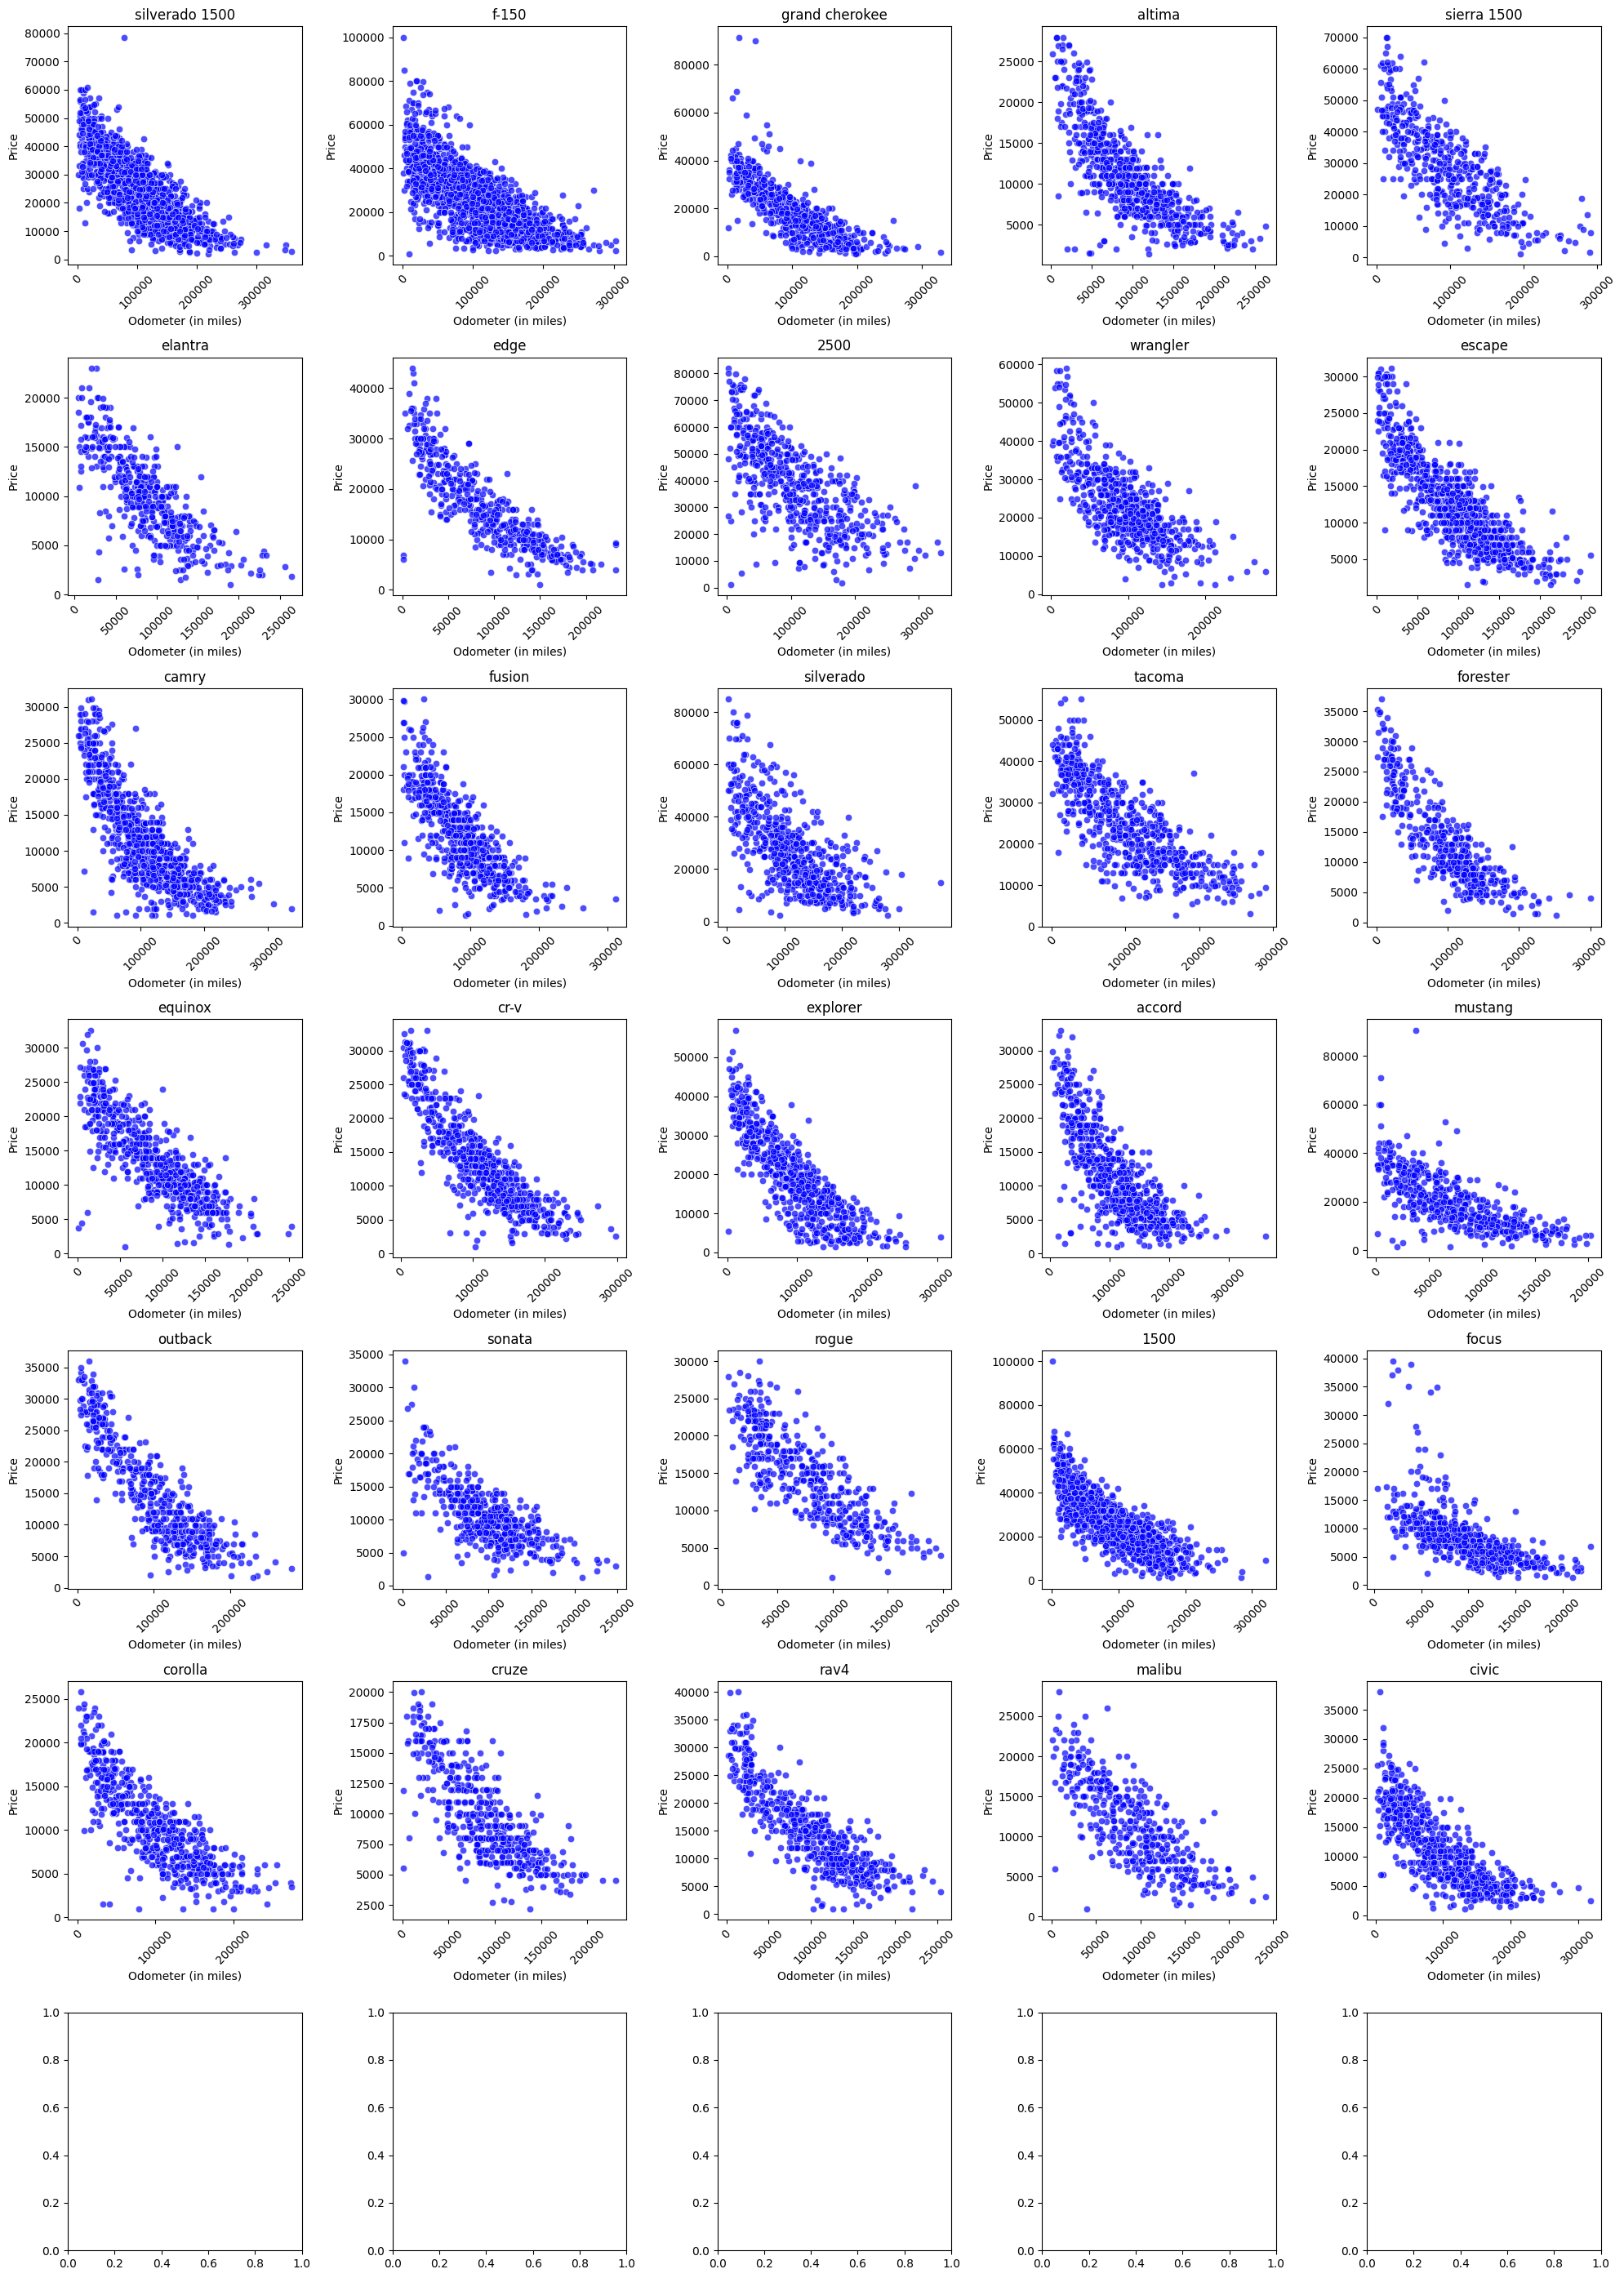

In [16]:
# Get the unique car models
models = bounded_odometer_df['model'].unique()

# Set up the number of rows and columns for the subplots (e.g., 2 rows and 5 columns)
n_rows = (len(models) // 5) + 1  # Adjust number of rows based on the number of models
n_cols = 5

# Set the size of the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

# Flatten the axes array to easily iterate through each subplot
axes = axes.flatten()

# Iterate over each model and plot on the corresponding subplot
for i, model in enumerate(models):
    ax = axes[i]
    model_data = bounded_odometer_df[bounded_odometer_df['model'] == model]

    # Create a scatter plot for the model
    sns.scatterplot(x='odometer', y='price', data=model_data, ax=ax, color='blue', alpha=0.7)

    # Set titles and labels for each subplot
    ax.set_title(model, fontsize=12)
    ax.set_xlabel('Odometer (in miles)', fontsize=10)
    ax.set_ylabel('Price', fontsize=10)

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Adjust layout for spacing and tight fit
plt.tight_layout()
plt.show()


From this plot, you can see for each of the models there is a clear relationship between price and odometer

## Cylinders

As shown by the table below, the majority of cars have either 4,6 or 8 cylinders, so I'm going to drop the rows that aren't because they are rare cases that have little data.


In [17]:
bounded_odometer_df['cylinder_count'].value_counts()

,count
cylinder_count,
4,10083
6,5475
8,4626
3,38
10,5
5,2
12,1


In [18]:
cylinder_filtered_df = bounded_odometer_df[bounded_odometer_df['cylinder_count'].isin([4, 6, 8])]
cylinder_filtered_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,31.453312,-100.464064,8,2015,odessa / midland,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,47.714927,-116.790784,8,2014,spokane,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,36.644835,-93.218011,6,2008,joplin,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,29.148519,-98.875934,6,2019,laredo,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,29.148519,-98.875934,4,2015,san antonio,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117179,9995,ford,fusion,gas,117138.0,clean,automatic,40.859538,-73.075599,4,2016,long island,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,44.971567,-93.488809,6,2010,minneapolis / st paul,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,45.197295,-93.901667,6,2018,minneapolis / st paul,good,mn
117195,4250,hyundai,elantra,gas,187570.0,clean,manual,38.479493,-90.741664,4,2010,"st louis, MO",good,il


## Year

The chart below shows the distribution of the Year that the car is made in our dataframe

<ipython-input-19-3b50d2f0b6dd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='car_year', data=cylinder_filtered_df, palette='viridis')


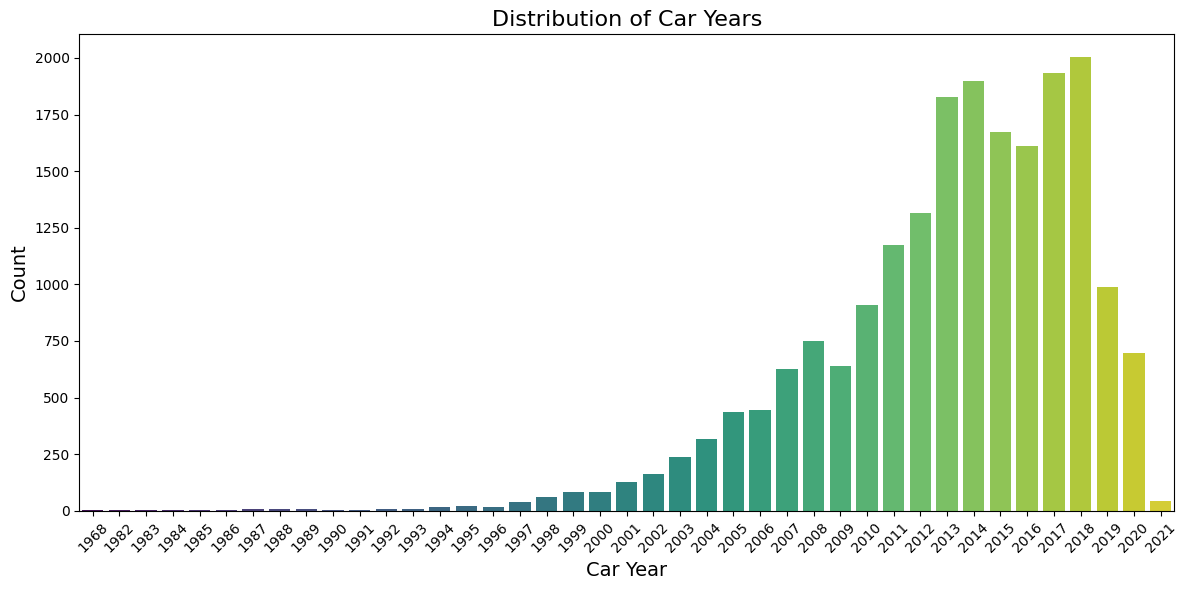

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(x='car_year', data=cylinder_filtered_df, palette='viridis')


plt.title('Distribution of Car Years', fontsize=16)
plt.xlabel('Car Year', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most of the cars are from after 2000. Not sure about this decision, but I'll drop the cars before 2000 as theres little data on those years and might be hard for the model to make a prediction. But as it's a linear numerical relationship between year and price (new cars usually more spenny) then it would probably manage having all of the years idk.

In [20]:
# Filter the DataFrame to include only rows where car_year is greater than or equal to 2000
filtered_by_year_df = cylinder_filtered_df[cylinder_filtered_df['car_year'] >= 2000]
filtered_by_year_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,31.453312,-100.464064,8,2015,odessa / midland,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,47.714927,-116.790784,8,2014,spokane,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,36.644835,-93.218011,6,2008,joplin,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,29.148519,-98.875934,6,2019,laredo,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,29.148519,-98.875934,4,2015,san antonio,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117179,9995,ford,fusion,gas,117138.0,clean,automatic,40.859538,-73.075599,4,2016,long island,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,44.971567,-93.488809,6,2010,minneapolis / st paul,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,45.197295,-93.901667,6,2018,minneapolis / st paul,good,mn
117195,4250,hyundai,elantra,gas,187570.0,clean,manual,38.479493,-90.741664,4,2010,"st louis, MO",good,il


This dataset is outdated, these are cars from 2021 and prices predicted by the model are only relevent to 2021 prices.

## Condition

As shown by the chart below, most cars claim to be in excellent or good condition. This column might be a bit redundent as the difference between good and excellent is quite subjective.

<ipython-input-21-389966e8587b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='car_condition', data=filtered_by_year_df, palette='Set2')


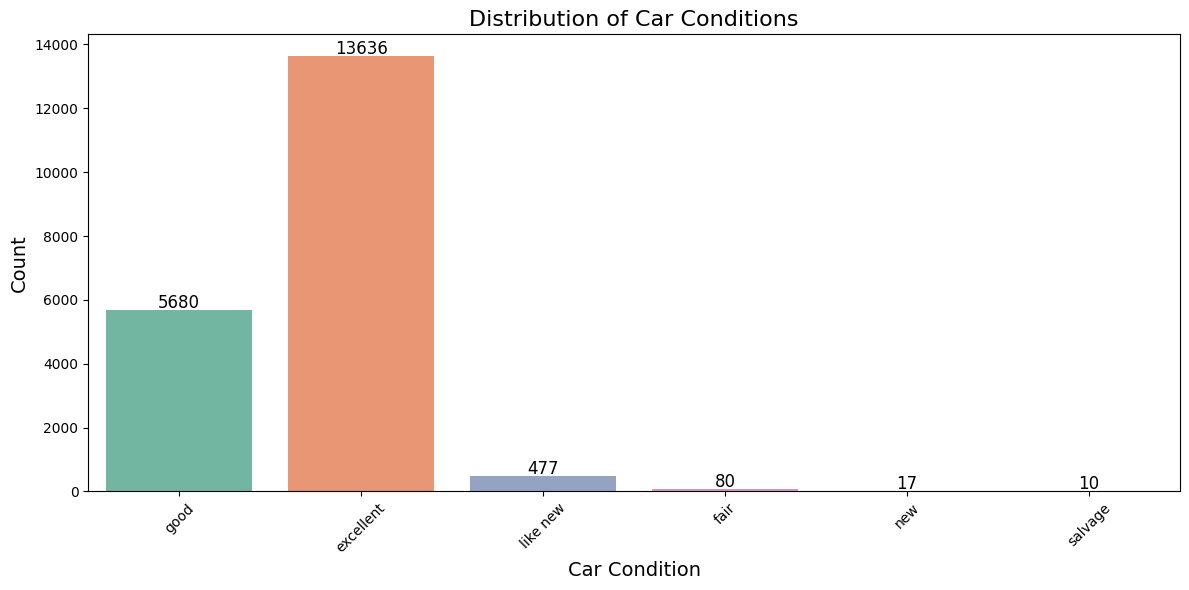

In [21]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Create the count plot
ax = sns.countplot(x='car_condition', data=filtered_by_year_df, palette='Set2')

# Add titles and labels
plt.title('Distribution of Car Conditions', fontsize=16)
plt.xlabel('Car Condition', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Annotate the count on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Going to get rid of the non-good/excellent rows.

In [22]:
filtered_condition_df = filtered_by_year_df[filtered_by_year_df['car_condition'].isin(['good', 'excellent'])]

In [23]:
filtered_condition_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,lat,long,cylinder_count,car_year,car_region,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,31.453312,-100.464064,8,2015,odessa / midland,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,47.714927,-116.790784,8,2014,spokane,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,36.644835,-93.218011,6,2008,joplin,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,29.148519,-98.875934,6,2019,laredo,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,29.148519,-98.875934,4,2015,san antonio,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117179,9995,ford,fusion,gas,117138.0,clean,automatic,40.859538,-73.075599,4,2016,long island,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,44.971567,-93.488809,6,2010,minneapolis / st paul,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,45.197295,-93.901667,6,2018,minneapolis / st paul,good,mn
117195,4250,hyundai,elantra,gas,187570.0,clean,manual,38.479493,-90.741664,4,2010,"st louis, MO",good,il


## Location (Region, lat/long, state)

### Region

Is region going to be a good feature column to represent location?

First of all, how many regions do we have atm?

In [24]:
# How many regions are we working with
filtered_condition_df['car_region'].nunique()

368

Below is a histogram showing how much data there is in the regions.

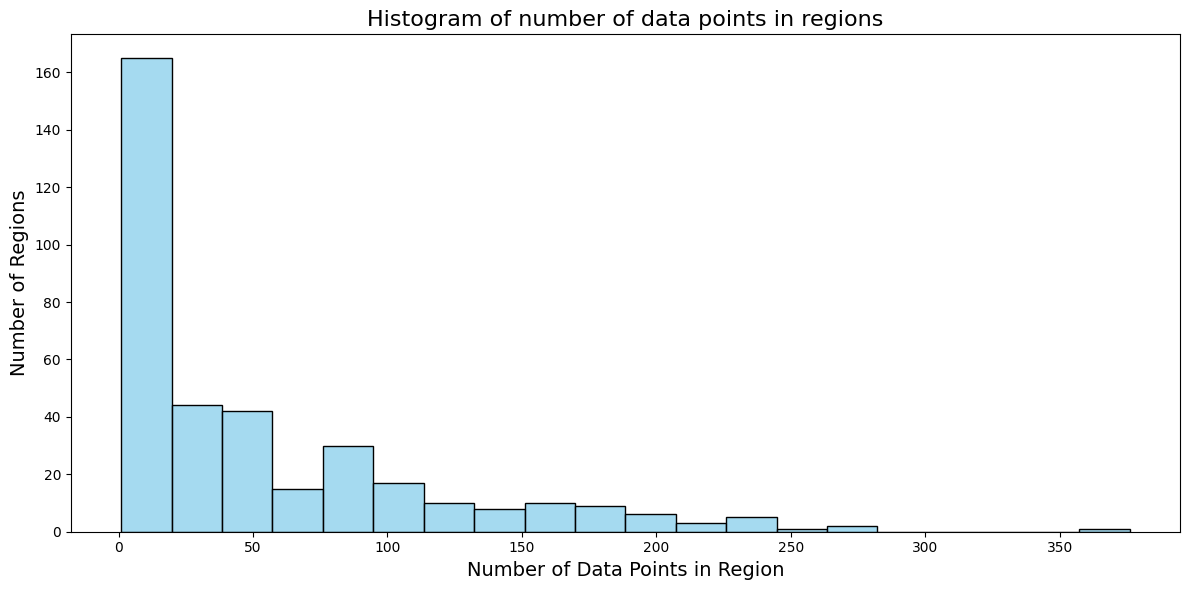

In [25]:
region_counts = filtered_condition_df['car_region'].value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(region_counts, bins=20, kde=False, color='skyblue')

plt.title('Histogram of number of data points in regions', fontsize=16)
plt.xlabel('Number of Data Points in Region', fontsize=14)
plt.ylabel('Number of Regions', fontsize=14)


plt.tight_layout()
plt.show()


Okay there's lots of regions with not much data. Let's see how many regions have less than 50 data points. The majority of them.

In [26]:
region_counts = filtered_condition_df['car_region'].value_counts()

regions_less_than_50 = region_counts[region_counts < 50]

regions_less_than_50


,count
car_region,
lincoln,49
twin falls,49
yuba-sutter,48
youngstown,46
jersey shore,46
...,...
san marcos,1
high rockies,1
clovis / portales,1


I don't think region is going to be a good representation for location. Let's try state.

### State

The plot below shows how each state compares price-wise

<ipython-input-27-cc7a8174d314>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='state', y='price', data=filtered_condition_df, order=state_medians.index, palette='Set2')


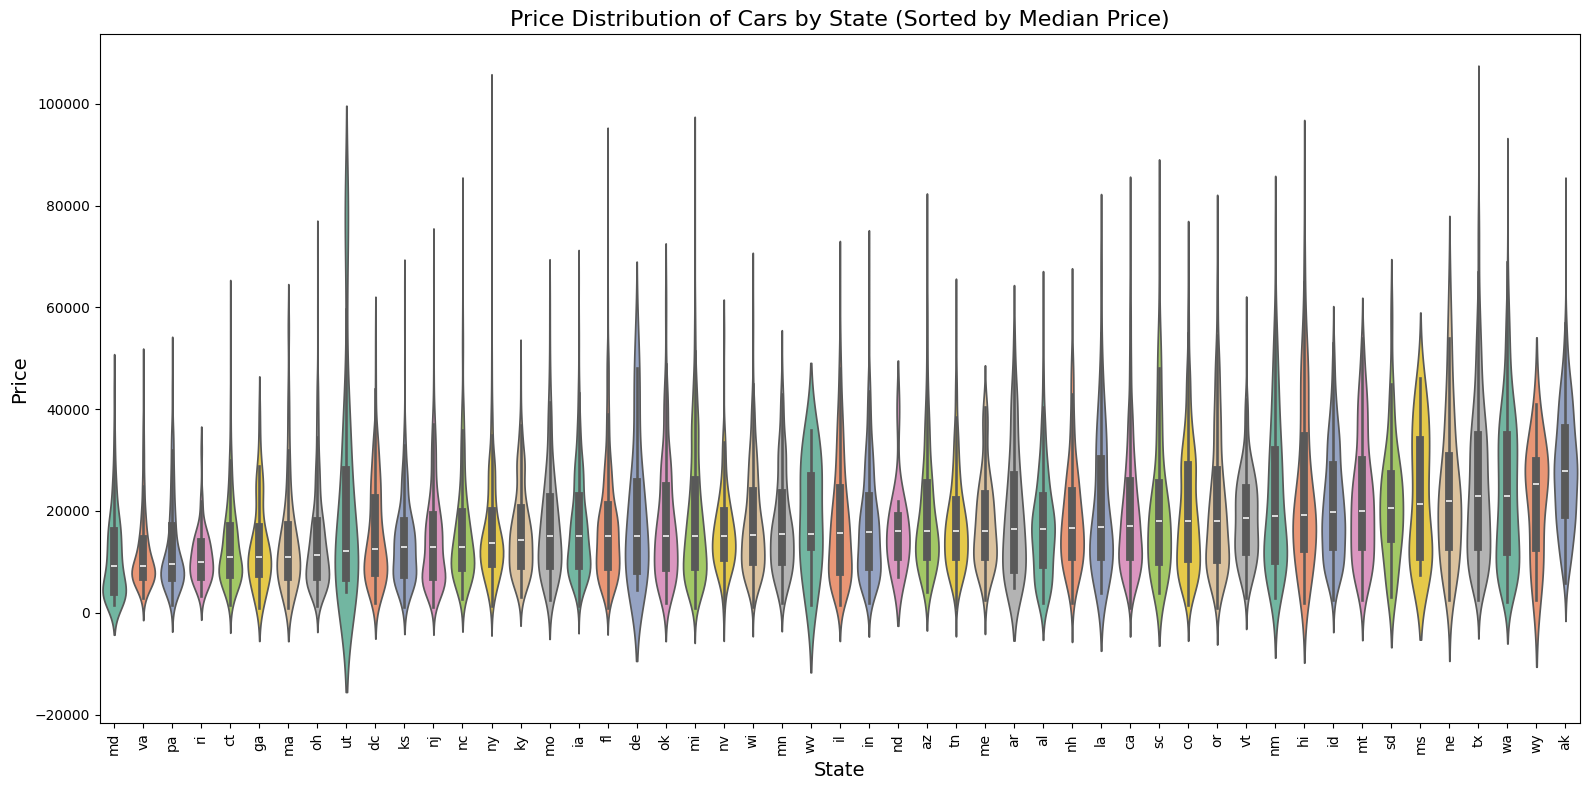

In [27]:
state_medians = filtered_condition_df.groupby('state')['price'].median().sort_values()
state_counts = filtered_condition_df['state'].value_counts()

plt.figure(figsize=(16, 8))
sns.violinplot(x='state', y='price', data=filtered_condition_df, order=state_medians.index, palette='Set2')

plt.title('Price Distribution of Cars by State (Sorted by Median Price)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Price', fontsize=14)


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


This plot clearly shows that price differs quite a bit depending on what state you're in.
va and ak both have a few hundred datapoints and there is a big difference in median price.

Below is a table that gives extra context to the violin plots by saying how much data there is in each state

In [28]:
state_medians = filtered_condition_df.groupby('state')['price'].median()
state_counts = filtered_condition_df['state'].value_counts()

state_summary = pd.DataFrame({
    'median_price': state_medians,
    'data_count': state_counts
})

state_summary.sort_values(by='median_price', ascending=True)


,median_price,data_count
state,,
md,9147.0,226
va,9282.5,426
pa,9495.0,452
ri,9997.5,52
ct,10950.0,243
ga,11000.0,119
ma,11000.0,369
oh,11264.0,846
ut,12095.0,48


Based on this data, I'm happy to use state as the location based feature column and will drop the other location-related columns from the dataframe.

In [29]:
location_df = filtered_condition_df.drop(columns=['lat', 'long', 'car_region'])
location_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,cylinder_count,car_year,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,8,2015,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,8,2014,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,6,2008,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,6,2019,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,4,2015,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...
117179,9995,ford,fusion,gas,117138.0,clean,automatic,4,2016,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,6,2010,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,6,2018,good,mn
117195,4250,hyundai,elantra,gas,187570.0,clean,manual,4,2010,good,il


## Transmission

The table below shows that the vast majority of transmissions are automatic. I'm going to remove the non-automatic rows.

In [30]:
location_df['transmission'].value_counts()

,count
transmission,
automatic,17886
manual,745
other,475


In [31]:
transmission_df = location_df[location_df['transmission'] == 'automatic']
transmission_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,cylinder_count,car_year,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,8,2015,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,8,2014,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,6,2008,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,6,2019,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,4,2015,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...
117178,4495,toyota,corolla,gas,63659.0,clean,automatic,4,2004,excellent,ny
117179,9995,ford,fusion,gas,117138.0,clean,automatic,4,2016,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,6,2010,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,6,2018,good,mn


## Title Status

The table below shows that the vast majority of data is 'clean' as its title status. So I'm going to remove the rows that aren't, so we can now assume that the cars we will be predicting the price of will be 'clean' cars.

In [32]:
transmission_df['title_status'].value_counts()

,count
title_status,
clean,17456
rebuilt,248
salvage,62
lien,17
missing,1


In [33]:
title_status_df = transmission_df[transmission_df['title_status']== 'clean']
title_status_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,cylinder_count,car_year,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,8,2015,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,8,2014,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,6,2008,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,6,2019,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,4,2015,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...
117178,4495,toyota,corolla,gas,63659.0,clean,automatic,4,2004,excellent,ny
117179,9995,ford,fusion,gas,117138.0,clean,automatic,4,2016,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,6,2010,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,6,2018,good,mn


Might be interesting to check if non-clean titles tend to have higher odometer readings than clean titles, because they get so beaten up after driving so far. If they do, then odometer data is related to title status,meaning it's not really a big deal dropping this column. We've dropped it anyway tho.

## Fuel


The table below shows that the vast majority of fuel is 'gas'. So I'm going to remove the rows that aren't gas, so we can now assume that the cars we will be predicting the price of will be gas powered cars.

In [34]:
title_status_df['fuel'].value_counts()

,count
fuel,
gas,16316
other,552
diesel,460
hybrid,87
electric,7


In [35]:
fuel_df = title_status_df[title_status_df['fuel'] == 'gas']
fuel_df

,price,manufacturer,model,fuel,odometer,title_status,transmission,cylinder_count,car_year,car_condition,state
1,25987,chevrolet,silverado 1500,gas,158855.0,clean,automatic,8,2015,good,tx
4,32995,ford,f-150,gas,106000.0,clean,automatic,8,2014,excellent,id
9,9777,jeep,grand cherokee,gas,223161.0,clean,automatic,6,2008,good,mo
14,31995,jeep,grand cherokee,gas,48966.0,clean,automatic,6,2019,good,tx
15,10995,nissan,altima,gas,103011.0,clean,automatic,4,2015,excellent,tx
...,...,...,...,...,...,...,...,...,...,...,...
117178,4495,toyota,corolla,gas,63659.0,clean,automatic,4,2004,excellent,ny
117179,9995,ford,fusion,gas,117138.0,clean,automatic,4,2016,excellent,ny
117184,8995,ford,explorer,gas,168843.0,clean,automatic,6,2010,excellent,mn
117191,30988,ford,explorer,gas,32015.0,clean,automatic,6,2018,good,mn


# dropping unwanted columns

Now we've investigated and cleaned all the columns, we can drop the one's we don't want anymore that are still in the dataframe

In [36]:
car_df = fuel_df.drop(columns=['manufacturer', 'fuel', 'title_status', 'transmission'])
car_df

,price,model,odometer,cylinder_count,car_year,car_condition,state
1,25987,silverado 1500,158855.0,8,2015,good,tx
4,32995,f-150,106000.0,8,2014,excellent,id
9,9777,grand cherokee,223161.0,6,2008,good,mo
14,31995,grand cherokee,48966.0,6,2019,good,tx
15,10995,altima,103011.0,4,2015,excellent,tx
...,...,...,...,...,...,...,...
117178,4495,corolla,63659.0,4,2004,excellent,ny
117179,9995,fusion,117138.0,4,2016,excellent,ny
117184,8995,explorer,168843.0,6,2010,excellent,mn
117191,30988,explorer,32015.0,6,2018,good,mn


# Pairplots and correlation graphs

Below is a pairplot graph, but only with a medium sample of the dataset as it takes a decent amount of computation. It could probably handle the whole dataset but would take like 20s-1min.

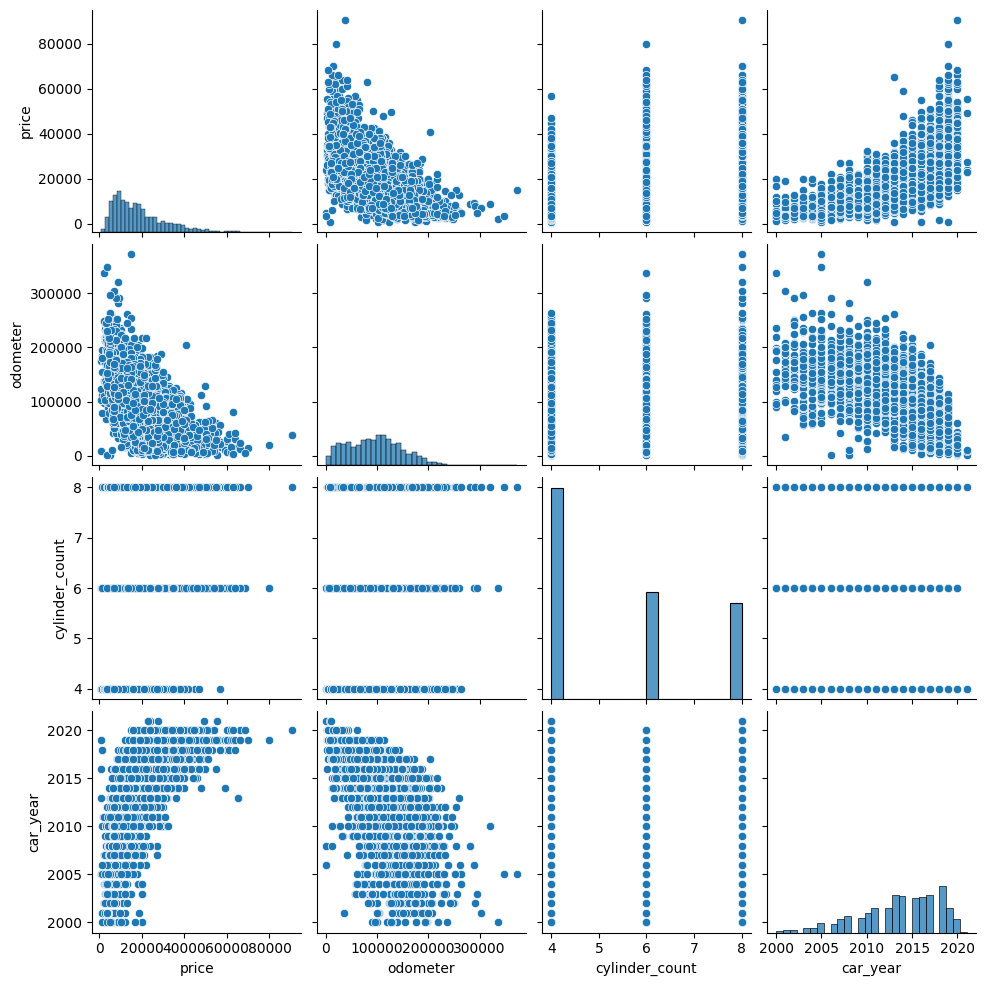

In [37]:
pairplot_df = car_df.sample(n=4000)
sns.pairplot(pairplot_df)

Below is a correlation heatmap, showing the correlation between each numerical column

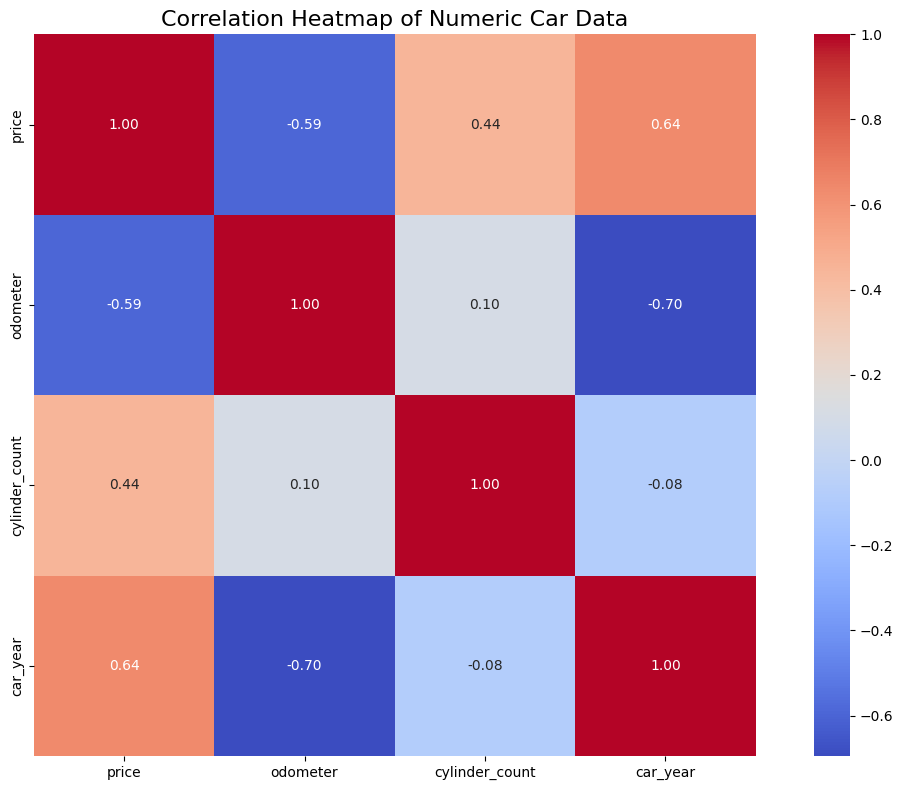

In [38]:
numeric_cols = car_df.select_dtypes(include=['number']).columns
correlation_matrix = car_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))  # Adjust the figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)

plt.title('Correlation Heatmap of Numeric Car Data', fontsize=16)

plt.tight_layout()
plt.show()


In [39]:
car_df.describe()

,price,odometer,cylinder_count,car_year
count,16316.0,16316.000000,16316.0,16316.0
mean,17934.206913,98723.345612,5.421672,2013.351189
std,11489.42716,53453.460329,1.624342,4.385567
min,1000.0,1000.000000,4.0,2000.0
25%,8999.0,56728.000000,4.0,2011.0
50%,14995.0,97812.000000,4.0,2014.0
75%,23995.0,134633.250000,6.0,2017.0
max,99999.0,372565.000000,8.0,2021.0


# Assumptions

Trying to keep track of the assumptions we made and what kind of car will have its price predicted best when the model is done.

- Gas Car
- Clean title status
- Automatic transmission
- It is being sold for a reasonable price, not given away for a few dollars or several hundered thousand dollars
- It has some miles on it's odometer, and not a stupid amount
- It is one of the popular car models that we have enough data for
- Is in good or excellent condition
- There is some price consistency within states
- 4,6,8 cylinders

there are probably more assumptions


The prices are only relevent from 2021 perspective

# normalising data and encoding

transformation plan

1. Price
Don't think any transformation is needed. Maybe do a log if we think the price distribution is very skewed

2. model
one hot encode

3. odometer
z score normalise

4. cylinder_count
leave as is

5. year

6. condition
good = 0
excellent = 1

7. state
one hot encode

In [40]:
car_df

,price,model,odometer,cylinder_count,car_year,car_condition,state
1,25987,silverado 1500,158855.0,8,2015,good,tx
4,32995,f-150,106000.0,8,2014,excellent,id
9,9777,grand cherokee,223161.0,6,2008,good,mo
14,31995,grand cherokee,48966.0,6,2019,good,tx
15,10995,altima,103011.0,4,2015,excellent,tx
...,...,...,...,...,...,...,...
117178,4495,corolla,63659.0,4,2004,excellent,ny
117179,9995,fusion,117138.0,4,2016,excellent,ny
117184,8995,explorer,168843.0,6,2010,excellent,mn
117191,30988,explorer,32015.0,6,2018,good,mn


Label encoding the condition. good = 0; excellent = 1

In [41]:
car_df['car_condition'] = car_df['car_condition'].map({'good': 0, 'excellent': 1})

z score normalise odometer

In [42]:
scaler = StandardScaler()
car_df['odometer'] = scaler.fit_transform(car_df[['odometer']])

one hot encoding model and state

In [43]:
car_df = pd.get_dummies(car_df, columns=['model'])

In [44]:
car_df = pd.get_dummies(car_df, columns=['state'])

All done

In [45]:
car_df

,price,odometer,cylinder_count,car_year,car_condition,model_1500,model_2500,model_accord,model_altima,model_camry,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
1,25987,1.124969,8,2015,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,32995,0.136135,8,2014,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,9777,2.328034,6,2008,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14,31995,-0.930882,6,2019,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
15,10995,0.080215,4,2015,1,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117178,4495,-0.655999,4,2004,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117179,9995,0.344509,4,2016,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117184,8995,1.311829,6,2010,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117191,30988,-1.248009,6,2018,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


need to replace all the models names that have a invalid characters like '-' and ' ' in their name with a safe character for big query

In [46]:
car_df.columns = car_df.columns.str.replace('-', '_')
car_df.columns = car_df.columns.str.replace(' ', '')
car_df

,price,odometer,cylinder_count,car_year,car_condition,model_1500,model_2500,model_accord,model_altima,model_camry,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
1,25987,1.124969,8,2015,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,32995,0.136135,8,2014,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,9777,2.328034,6,2008,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14,31995,-0.930882,6,2019,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
15,10995,0.080215,4,2015,1,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117178,4495,-0.655999,4,2004,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117179,9995,0.344509,4,2016,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117184,8995,1.311829,6,2010,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117191,30988,-1.248009,6,2018,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Split into train (to be split into train and evaluation in bqML and test (for prediction) 85/15

In [47]:
train_df, test_df = train_test_split(car_df, test_size=0.15, random_state=42)

Saving the dataframe in the Machine Learning dataset

In [48]:
train_df.to_gbq(destination_table='Machine_learning.training_car_data', project_id='dt-grad-emea3-cap-dev', if_exists='replace')
test_df.to_gbq(destination_table='Machine_learning.test_car_data', project_id='dt-grad-emea3-cap-dev', if_exists='replace')

<ipython-input-48-d379cbba312e>:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  train_df.to_gbq(destination_table='Machine_learning.training_car_data', project_id='dt-grad-emea3-cap-dev', if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 7281.78it/s]
<ipython-input-48-d379cbba312e>:2: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  test_df.to_gbq(destination_table='Machine_learning.test_car_data', project_id='dt-grad-emea3-cap-dev', if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]
